# Lake Victoria levels analysis : create interpolated lake level time series 1896-2022

## Data sources: 
- DAHITI, 2022 March download
- WMO Hydromet 1948-1995/1996 (from Vanderkelen et al 2018)
- HC monthly data late 1896-2017

## What this notebook does: 
- analysis of DAHITI and WMO timeseries 
- merge together the DH and HM and HC timeseries late 1800s-2022
    - calculates average difference from overlapping dates
    - corrects timeseries to match DH
    - overwrites overlapping periods with DH
    - interpolate to daily resolution
    
## Output: 
- lake level DH + HM (1948-2022) using DH 2022 data and overwriting DH on top of HM, raw (lakelevel_all_raw_DH22.txt and csv) and interpolated to daily resolution (lakelevel_all_intr_DH22.txt and csv)
- lake level HC + DH + HM (1896-2022) lakelevel_ext_intr_HCDH22.csv

## Figures:
Fig. 1 of paper (lake levels with high and low lake levels labelled)

rosa.pietroiusti@vub.be



In [1]:

import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pprint
import os , glob
from osgeo import gdal
import scipy as scipy
from scipy import stats
import sklearn 
import datetime
from datetime import datetime
from matplotlib.pyplot import cm

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [61]:
# make figures directory
figDIR = os.path.join(os.path.dirname(os.getcwd()), '..', 'figures')
fig_path = os.path.join(figDIR, 'figures_1_feb23_extendedlevels')

if os.path.exists(fig_path):
    print("The directory", fig_path, "exists!")
else:
    os.makedirs(fig_path)
    print("The directory", fig_path, "was made!")

outdir = os.path.join(os.path.dirname(os.getcwd()), '..', 'data/data-modified/lakelevels/')


The directory c:\Users\rpietroi\OneDrive - Vrije Universiteit Brussel\repos_cloud\lakevic-eea\lakevic-eea-clean\lakevic-eea-scripts\lakevic-eea-scripts\..\figures\figures_1_feb23_extendedlevels exists!


## 1) DAHITI + Hydromet data

From Dahiti database, downloaded March 2022

- *1992-09-27 to 2022-03-03*

In [13]:
# Read in data 
datadir = os.path.join('../../data/input-data/lakelevels/')
data_2022 = pd.read_csv(os.path.join(datadir,'DAHITI_lakelevels_070322.csv')) 
data_2022['date'] = pd.to_datetime(data_2022['date'])
data_2022

,date,water level,error
0,1992-09-27,1135.000,0.000
1,1992-10-07,1135.023,0.001
2,1992-10-17,1135.032,0.000
3,1992-10-27,1134.958,0.000
4,1992-11-06,1135.035,0.000
...,...,...,...
1053,2022-01-22,1136.143,0.001
1054,2022-02-01,1136.145,0.001
1055,2022-02-11,1136.199,0.001
1056,2022-02-21,1136.227,0.001


10.169347209082304
[(9.0, 88), (10.0, 946), (19.0, 2), (20.0, 18), (29.0, 1), (30.0, 1), (40.0, 1)]


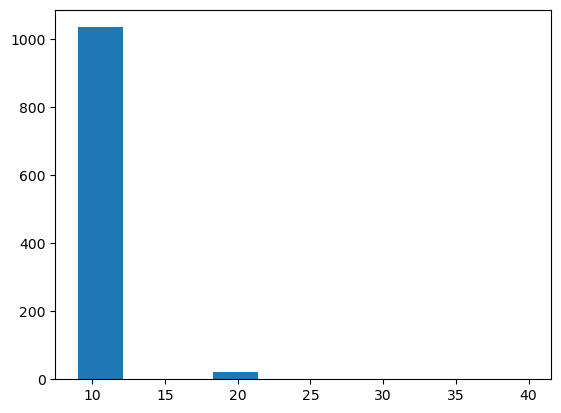

In [14]:
# Temporal resolution of DAHITI 2022 data 

dt = np.diff(data_2022['date'])
print(dt.mean() / np.timedelta64(1, "D"))

dt_hist = (dt / np.timedelta64(1, "D"))
dt_list = dt_hist.tolist()
plt.hist(dt_hist)

print(list(zip(*np.unique(dt_hist, return_counts=True))))

In [15]:
data_2022[['water level']].agg(['min', 'max', 'mean'])

,water level
min,1133.734000
max,1136.777000
mean,1135.111718


In [16]:
data_2022 = data_2022.set_index(['date'])
data_2022

,water level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001



### Merge together HYDROMET and DAHITI data  

In [17]:
# Read in data - This is new version with 2022 data

DAHITI = data_2022.copy()
DAHITI=DAHITI.rename(columns={"water level": "water_level"})
DAHITI


,water_level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


In [18]:
HYDROMET_raw = pd.read_csv(os.path.join(datadir,'Jinja_lakelevels_Van.txt'), sep = "\t",  header = None)
HYDROMET_raw

,0,1,2,3,4
0,1948,1,1,1134.097,11.210
1,1948,1,2,1134.102,11.215
2,1948,1,3,1134.062,11.175
3,1948,1,4,1134.052,11.165
4,1948,1,5,1134.077,11.190
...,...,...,...,...,...
17741,1996,7,28,1134.777,11.890
17742,1996,7,29,1134.757,11.870
17743,1996,7,30,1134.752,11.865
17744,1996,7,31,1134.717,11.830


In [19]:
HYDROMET_raw.columns = ['year', 'month', 'day', 'water level', 'meas']
HYDROMET_dates = pd.to_datetime(HYDROMET_raw[['year', 'month', 'day']])
df = pd.DataFrame(HYDROMET_dates, columns = ['date'])
df[['water_level', 'meas']] = HYDROMET_raw[['water level', 'meas']]
HYDROMET = df.set_index(['date'])
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [20]:
# Replace HYDROMET zeros with NaN, so that Matplotlib won't connect the points

HYDROMET.query('water_level == 0')

,water_level,meas
date,,
1977-01-01,0.0,0.0
1977-01-02,0.0,0.0
1977-01-03,0.0,0.0
1977-01-04,0.0,0.0
1977-01-05,0.0,0.0
...,...,...
1982-11-28,0.0,0.0
1982-11-29,0.0,0.0
1982-11-30,0.0,0.0


In [21]:
HYDROMET['water_level'] = HYDROMET['water_level'].replace(0, np.nan)
HYDROMET['meas'] = HYDROMET['meas'].replace(0, np.nan)
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [22]:
HYDROMET.query('water_level != water_level')

,water_level,meas
date,,
1977-01-01,NaN,NaN
1977-01-02,NaN,NaN
1977-01-03,NaN,NaN
1977-01-04,NaN,NaN
1977-01-05,NaN,NaN
...,...,...
1982-11-28,NaN,NaN
1982-11-29,NaN,NaN
1982-11-30,NaN,NaN


In [23]:
# Get summary stats 

DAHITI[['water_level']].agg(['min', 'max', 'mean']) 

,water_level
min,1133.734000
max,1136.777000
mean,1135.111718


In [24]:
HYDROMET[['water_level']].agg(['min', 'max', 'mean']) 

,water_level
min,1133.447000
max,1136.277000
mean,1134.686917


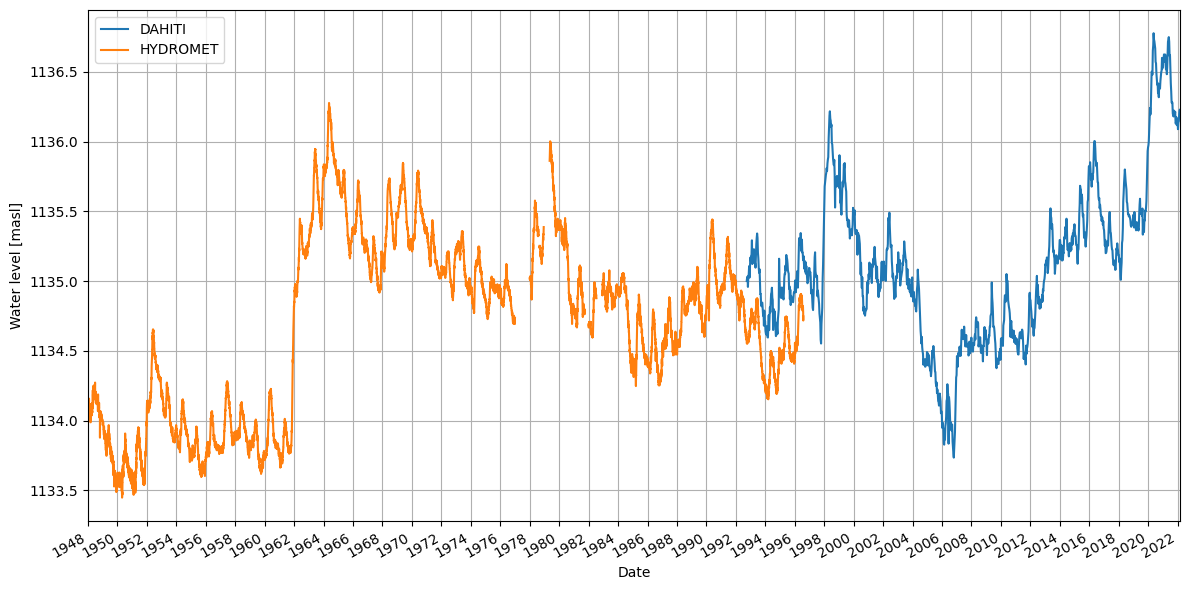

In [25]:
# Plot raw dahiti and hydromet

left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
DAHITI['water_level'].plot(ax=ax, label="DAHITI")
HYDROMET['water_level'].plot(ax=ax, label="HYDROMET")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()


### Snap the two time-series together

In [26]:
# Merge the two time-series, key on date, keep all observations (outer)
d_HYDROMET = HYDROMET.drop(['meas'], axis=1)
d_DAHITI = DAHITI.drop(['error'], axis=1)
df_merge = pd.merge(d_HYDROMET, d_DAHITI, how='outer', on='date')
df_merge.columns = ['HYDROMET', 'DAHITI']
df_merge # 18625 rows

# Get only the overlapping observations
df_overlap = df_merge.query('HYDROMET == HYDROMET & DAHITI == DAHITI')
df_overlap # 137 rows [1992-09-27 : 1996-07-26] 

,HYDROMET,DAHITI
date,,
1992-09-27,1134.567,1135.000
1992-10-07,1134.577,1135.023
1992-10-17,1134.567,1135.032
1992-10-27,1134.597,1134.958
1992-11-06,1134.582,1135.035
...,...,...
1996-06-17,1134.877,1135.214
1996-06-27,1134.872,1135.297
1996-07-07,1134.807,1135.204


In [27]:
avg_diff = (df_overlap['DAHITI'] - df_overlap['HYDROMET']).mean() # DAHITI overestimates vs. HYDROMET
n_diff = len(df_overlap)
std_diff = (df_overlap['DAHITI'] - df_overlap['HYDROMET']).std()
print('avg_diff =', avg_diff,  'n_diff =', n_diff, 'std_diff =', std_diff)
print('avg_diff_r =', round(avg_diff,3), 'std_diff_r =', round(std_diff,3) )

# 2022 data: Avg diff is 43.2 cm +/- 5.24 cm (one std)


avg_diff = 0.4319488746195349 n_diff = 137 std_diff = 0.05239589301085615
avg_diff_r = 0.432 std_diff_r = 0.052


In [28]:
# Snap the two timeseries together, add avg diff to HYDROMET 

HYDROMET_corr = HYDROMET.copy()
HYDROMET_corr['water_level'] = HYDROMET['water_level'] + round(avg_diff,3)
HYDROMET_corr

,water_level,meas
date,,
1948-01-01,1134.529,11.210
1948-01-02,1134.534,11.215
1948-01-03,1134.494,11.175
1948-01-04,1134.484,11.165
1948-01-05,1134.509,11.190
...,...,...
1996-07-28,1135.209,11.890
1996-07-29,1135.189,11.870
1996-07-30,1135.184,11.865


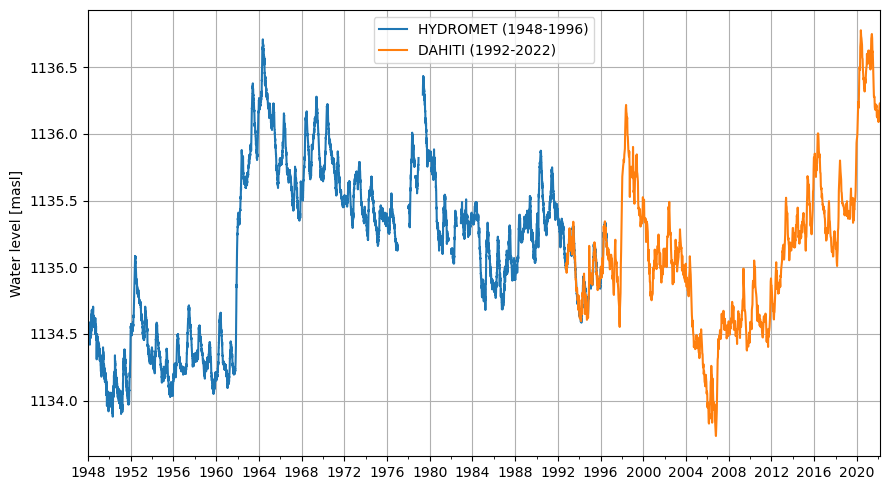

In [29]:
left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(9, 5))
HYDROMET_corr['water_level'].plot(ax=ax, label="HYDROMET (1948-1996)")
DAHITI['water_level'].plot(ax=ax, label="DAHITI (1992-2022)")
ax.grid(True)
ax.legend(loc=9)
plt.xlabel("")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(4))
ax.xaxis.set_minor_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()


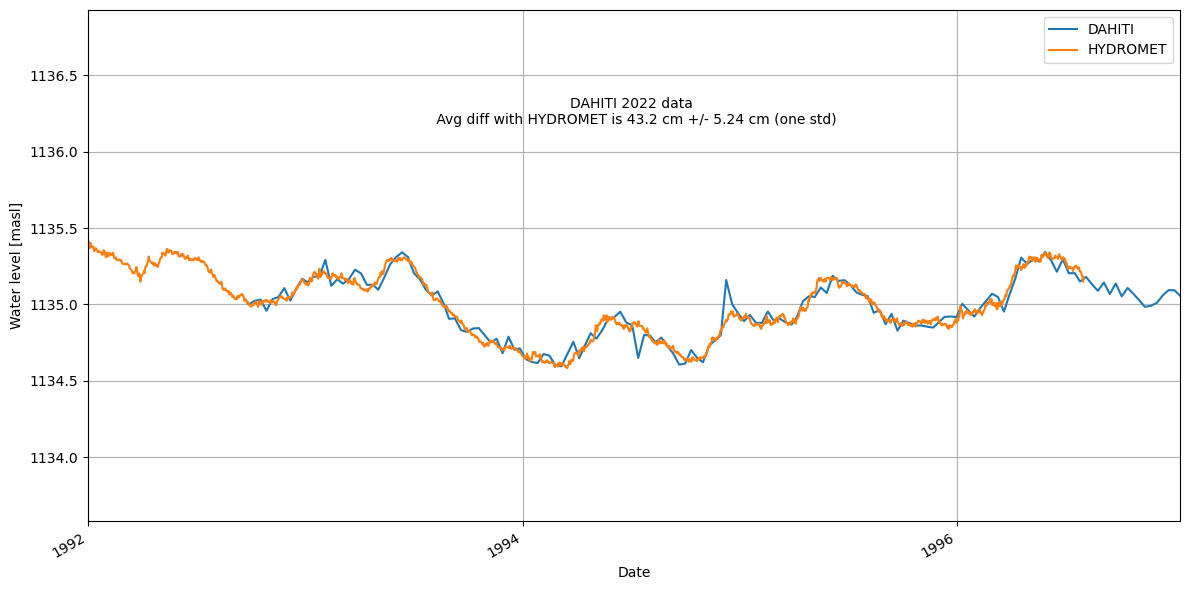

In [30]:
# 2022 data

left = '1992-01-01'
right = '1997-01-10'

fig, ax = plt.subplots(figsize=(12, 6))
DAHITI['water_level'].plot(ax=ax, label="DAHITI")
HYDROMET_corr['water_level'].plot(ax=ax, label="HYDROMET")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.text(0.5, 0.8, "DAHITI 2022 data \n Avg diff with HYDROMET is 43.2 cm +/- 5.24 cm (one std)",
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

#plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI22_HYDROMET_overlap.png'))

In [31]:
# Hydromet has more than 3 sig figs, round to 3 sig figs 

# 1964 RECORD
# 1964-05-15, 1136.68 masl, 13.39 m in situ

HYDROMET_corr[HYDROMET_corr['water_level']==HYDROMET_corr['water_level'].max()].round(3)

,water_level,meas
date,,
1964-05-15,1136.709,13.39


In [32]:
print('HYDROMET max =',HYDROMET_corr['water_level'].max(), 'HYDROMET max in situ =',HYDROMET_corr['meas'].max() )
geoid_corr = HYDROMET_corr['water_level'].max() - HYDROMET_corr['meas'].max()
print('HYDROMET geoid corr =',geoid_corr)



HYDROMET max = 1136.70900034332 HYDROMET max in situ = 13.3900003433227
HYDROMET geoid corr = 1123.3189999999972


In [33]:
geoid = pd.DataFrame(HYDROMET_corr['water_level'] - HYDROMET_corr['meas'])
geoid.columns = ['geoidcorr']
geoid.geoidcorr.unique()

# The geoid correction constant 1123.319 meters added to the in situ measurement

array([1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319,      nan])

In [35]:
# 2020 RECORD
# 2020-05-17

DAHITI[DAHITI['water_level']==DAHITI['water_level'].max()]

,water_level,error
date,,
2020-05-17,1136.777,0.0


In [36]:
print('DAHITI max =', DAHITI['water_level'].max())
print('DAHITI max - HYDROMET max =', DAHITI['water_level'].max() - HYDROMET_corr['water_level'].max())
print('DAHITI est in situ =', DAHITI['water_level'].max() - geoid_corr)
print('DAHITI est in situ (round) =', DAHITI['water_level'].max() - round(geoid_corr,3))

DAHITI max = 1136.777
DAHITI max - HYDROMET max = 0.06799965668005825
DAHITI est in situ = 13.458000000002812
DAHITI est in situ (round) = 13.458000000000084


### Correct for difference


In [37]:
startHYDROMET = np.datetime64('1948-01-01')
endHYDROMET = np.datetime64('1996-08-01')

startDAHITI = np.datetime64('1992-09-27')
endDAHITI = np.datetime64('2022-03-03') 

HYDROMET_keep = HYDROMET_corr.loc[ startHYDROMET : (startDAHITI - pd.Timedelta("1 day")) ]
HYDROMET_keep = HYDROMET_keep.drop(columns=['meas'])
HYDROMET_keep

# Overwriting time-series with DH where available

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
1992-09-22,1135.034
1992-09-23,1135.024
1992-09-24,1135.009


In [38]:
DAHITI_keep = DAHITI.drop(columns=['error'])
DAHITI_keep

,water_level
date,
1992-09-27,1135.000
1992-10-07,1135.023
1992-10-17,1135.032
1992-10-27,1134.958
1992-11-06,1135.035
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [39]:
df_list = [HYDROMET_keep,DAHITI_keep]
lakelevels_all_raw = pd.concat(df_list, ignore_index=False)
pd.set_option("display.precision", 8)
lakelevels_all_raw

,water_level
date,
1948-01-01,1134.52900004
1948-01-02,1134.53400015
1948-01-03,1134.49400019
1948-01-04,1134.48399996
1948-01-05,1134.50899958
...,...
2022-01-22,1136.14300000
2022-02-01,1136.14500000
2022-02-11,1136.19900000


In [40]:
# Round to 3 sig figs 

lakelevels_all = lakelevels_all_raw.round(3)
pd.set_option("display.precision", 8)
lakelevels_all

# Merge of DAHITI and HYDROMET, with DAHITI overwriting HYDROMET from DAHITI start date (1992-09-27)
# Data gaps from HYDROMET
# Resolution decreases from DAHITI having lower res than HYD
# need to linearly interpolate missing data 


,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [41]:
meanL = lakelevels_all['water_level'].mean()
maxL = lakelevels_all['water_level'].max()
minL = lakelevels_all['water_level'].min()
mtrim = stats.trim_mean(lakelevels_all[['water_level']], 0.1)
mtrim = mtrim.flatten().tolist()[0]
p10 = scipy.stats.scoreatpercentile(lakelevels_all[['water_level']], 10) # 10th percentile 
p90 = scipy.stats.scoreatpercentile(lakelevels_all[['water_level']], 90) # 90th percentile 

print('meanL =', meanL, 'maxL =', maxL, 'minL =', minL, 'range =', maxL-minL )
print('mtrim =', mtrim, 'p10 =', p10, 'p90 =', p90 )
print('start date =', left, 'enddate =', right)

#meanL = 1135.1319353655604 maxL = 1136.777 minL = 1133.734 range = 3.04300000000012
#mtrim = 1135.1791611953165 p10 = 1134.229 p90 = 1136.104


meanL = 1135.1319353655604 maxL = 1136.777 minL = 1133.734 range = 3.04300000000012
mtrim = 1135.1791611953165 p10 = 1134.229 p90 = 1136.104
start date = 1992-01-01 enddate = 1997-01-10


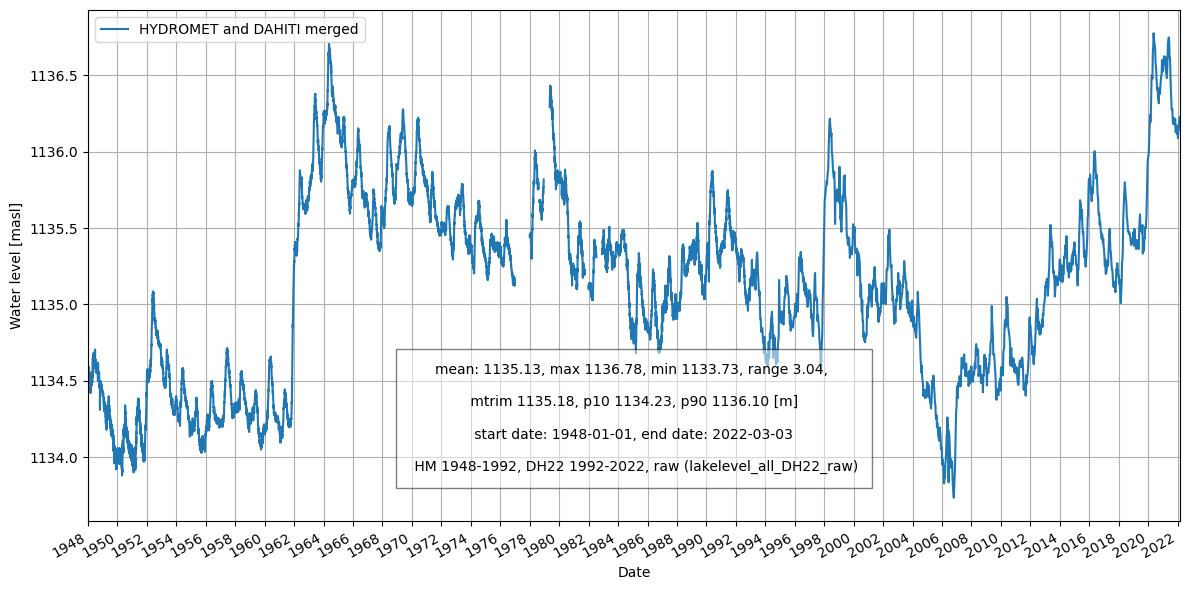

In [42]:
left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
lakelevels_all['water_level'].plot(ax=ax, label="HYDROMET and DAHITI merged")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
plot_text = ('mean: {:.2f}, max {:.2f}, min {:.2f}, range {:.2f}, \n \n mtrim {:.2f}, p10 {:.2f}, p90 {:.2f} [m] \n \n start date: {}, end date: {} \n \n HM 1948-1992, DH22 1992-2022, raw (lakelevel_all_DH22_raw)'
             .format(meanL, maxL, minL, maxL-minL, mtrim, p10,p90, left, right))  #, start date {:.3f}, end date {:.3f} 
#plot_text2 = "start date: %s, end date %s years old." %(left, right)
ax.text(0.5, 0.2, (plot_text), # , left, right
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'lakelevel_all_DH22_raw_annotate.png'))

# Merge of DAHITI and HYDROMET, with DAHITI overwriting HYDROMET from DAHITI start date (1992-09-27)
# Data gaps from HYDROMET
# Resolution decreases in overlap period from DAHITI having lower res than HYD

In [43]:
# Save lake levels merged, not interpolated

lakelevels_all
#lakelevels_all.to_csv(os.path.join(outdir,'lakelevel_all_raw_DH22.csv'),sep=',', index=True, header=True)

# Merged raw time-series not interpolated, DH overwrites HM from 1992. Time-series goes up to march 2022 (end of available data)

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


### interpolate to daily resolution

In [44]:
# Interpolate to daily res and round to 3 sig figs (number of DAHITI sig figs) - I lose the error measurements of Dahiti... 

lakelevels_intr = lakelevels_all.resample('D').asfreq().interpolate(method='linear').round(3)
lakelevels_intr

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-02-27,1136.228
2022-02-28,1136.228
2022-03-01,1136.229


In [45]:
# Export as csv 

#lakelevels_intr.to_csv(os.path.join(outdir,'lakelevel_all_intr_DH22.csv'),sep=',', index=True, header=True)

# Merged time-series interpolated, DH overwrites HM from 1992. Time-series goes up to march 2022 (end of available data)



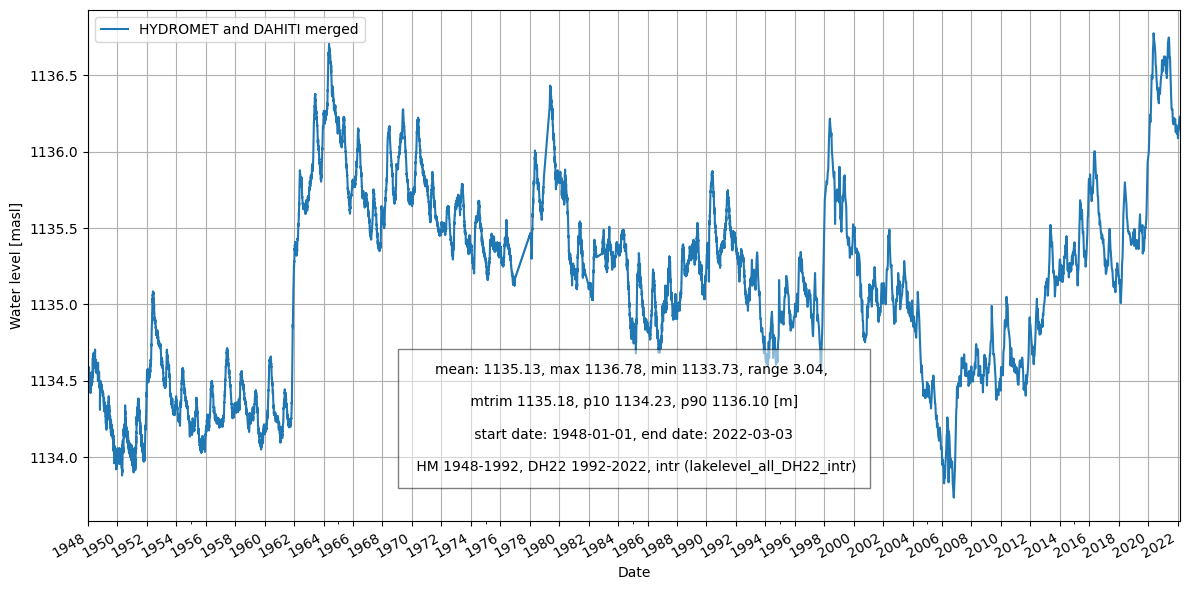

In [46]:
# Plot the interpolated lake levels 



left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
lakelevels_intr['water_level'].plot(ax=ax, label="HYDROMET and DAHITI merged")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
plot_text = ('mean: {:.2f}, max {:.2f}, min {:.2f}, range {:.2f}, \n \n mtrim {:.2f}, p10 {:.2f}, p90 {:.2f} [m] \n \n start date: {}, end date: {} \n \n HM 1948-1992, DH22 1992-2022, intr (lakelevel_all_DH22_intr)'
             .format(meanL, maxL, minL, maxL-minL, mtrim, p10,p90, left, right))  #, start date {:.3f}, end date {:.3f} 
ax.text(0.5, 0.2, (plot_text),
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'lakelevel_all_DH22_intr_annotate.png'))


## 2) DAHITI + Hydromet + UKCEH data

In [50]:

# From UKCEH from 1896 monthly data
lakelevels_file = os.path.join(datadir,'no-track/HoughtonCarr_lakelevels.csv')
lakelevels_HC = pd.read_csv(lakelevels_file, header=None)

# Clean UKCEH levels 
startdate = np.datetime64('1896-01')
enddate = np.datetime64('2017-12')
alldays = pd.DataFrame(pd.date_range(start=startdate,end=enddate, freq='MS'))

df_HC = pd.merge(alldays, lakelevels_HC.iloc[:,2], left_index=True, right_index=True)
df_HC.columns = ['date', 'levels']
df_HC = df_HC.set_index('date')
df_HC

,levels
date,
1896-01-01,11.57
1896-02-01,11.50
1896-03-01,11.51
1896-04-01,11.53
1896-05-01,11.53
...,...
2017-08-01,11.84
2017-09-01,11.83
2017-10-01,11.86


In [48]:
lakelevels_intr # DAHITI & Hydromet 

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-02-27,1136.228
2022-02-28,1136.228
2022-03-01,1136.229


In [51]:
df_HC[df_HC['levels'] == df_HC['levels'].max()]

,levels
date,
1964-05-01,13.33


In [57]:
# Turn DAHITI and HYDROMET RAW to in situ to combine with HC
geoid_corr =  1122.887
HM_to_DH_corr = 0.432
print(geoid_corr + HM_to_DH_corr)

df_new_insitu = lakelevels_all['water_level']   - geoid_corr - HM_to_DH_corr
df_new_insitu = pd.DataFrame(df_new_insitu)
df_new_insitu

1123.319


,water_level
date,
1948-01-01,11.210
1948-01-02,11.215
1948-01-03,11.175
1948-01-04,11.165
1948-01-05,11.190
...,...
2022-01-22,12.824
2022-02-01,12.826
2022-02-11,12.880


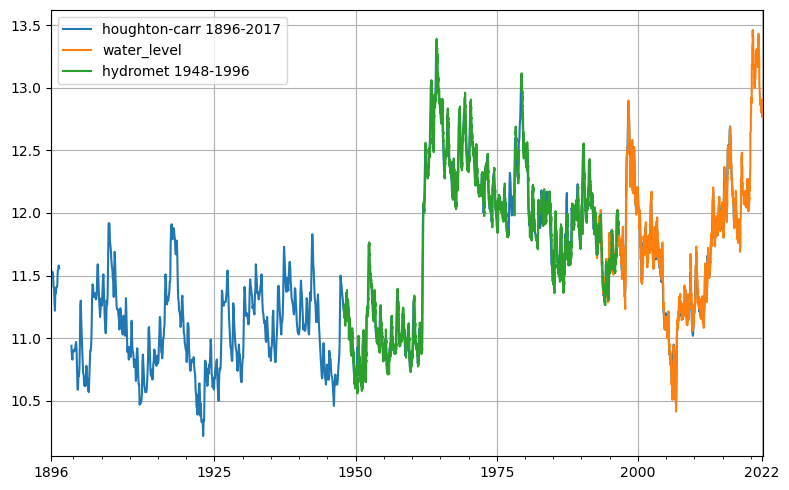

In [58]:
# Plot together, check that they agree

# set x axis labels
xlist = pd.to_datetime([1896, 1925, 1950, 1975,2000,2022], format='%Y')

fig, ax = plt.subplots(figsize=(8, 5))
df_HC['levels'].plot(ax=ax, label='houghton-carr 1896-2017') # houghton-carr data
df_new_insitu.loc['1992-9-1':].plot(ax=ax, label='dahiti 1992-2022') # dahiti data
HYDROMET['meas'].plot(ax=ax, label='hydromet 1948-1996') # hydromet data
ax.grid(True)
ax.legend()
plt.xlabel("")

# Set xaxis labels
ax.xaxis.set_ticks(xlist)
ax.xaxis.set_ticklabels(xlist.strftime("%Y"))


fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'LL_plot_extended_1896_2022_allsources_insitu_v2.png'),dpi=300)

### merge, interpolate to daily and save as csv 


In [59]:
frames = [df_HC['levels'].loc[:'1947-12-01'], df_new_insitu['water_level'].loc[:]]
unified_levels = pd.DataFrame(pd.concat(frames), columns=['water_level'])
unified_levels

,water_level
date,
1896-01-01,11.570
1896-02-01,11.500
1896-03-01,11.510
1896-04-01,11.530
1896-05-01,11.530
...,...
2022-01-22,12.824
2022-02-01,12.826
2022-02-11,12.880


In [60]:

unified_levels_intr = unified_levels.resample('D').asfreq().interpolate(method='linear').round(3)
#unified_levels_intr.to_csv(os.path.join(outdir,'lakelevel_ext_intr_HCDH22.csv'),sep=',', index=True, header=True)
unified_levels_intr

,water_level
date,
1896-01-01,11.570
1896-01-02,11.568
1896-01-03,11.565
1896-01-04,11.563
1896-01-05,11.561
...,...
2022-02-27,12.909
2022-02-28,12.909
2022-03-01,12.910


# Plot Fig. 1 paper

0
2020-05-17 00:00:00
1
1964-05-15 00:00:00
2
1979-05-23 00:00:00
3
1998-05-22 00:00:00
4
1906-05-01 00:00:00
5
1917-06-01 00:00:00
6
1942-05-01 00:00:00
7
1923-01-01 00:00:00
8
2006-10-21 00:00:00


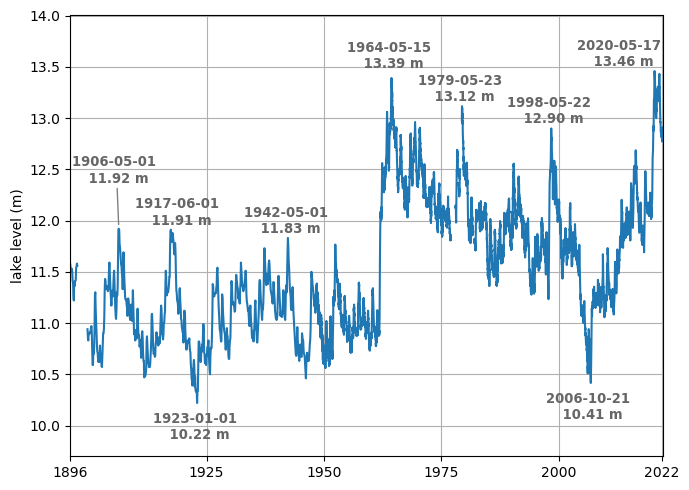

In [62]:
# plot Figure 1 of paper levels labelled
# UKCEH 1896-1948, hydromet 1948-1992, dahiti 1992-2022
# including also pre-1964 peaks 
# with 1917 peak as well
# with month-day

# Get extreme high levs
high_levs = unified_levels[unified_levels['water_level'] > 1136 - 1123.319]

# Get high levs before 1960s spike
high_levs = pd.concat([unified_levels[unified_levels['water_level'] > 11.7].loc[:'1963-01-01'], high_levs] )
list_years = np.unique(high_levs.index.year)

# Pick one per year
high_dates = []
high_levs_list =[]

for i in list_years:
    filter_condition = (high_levs.index.year == i)
    df_filter = high_levs.loc[filter_condition]
    maxL = max(df_filter['water_level'])
    maxday = df_filter[df_filter['water_level'] == maxL].index[0]
    high_levs_list.append(maxL)
    high_dates.append(maxday)
    
# Manually select only ones I want to show
data = {'date': high_dates,
        'level': high_levs_list
        }
df = pd.DataFrame(data)
df = df.sort_values(by='level', ascending=False).reset_index(drop=True)
select = [0,2,3,9,16,17,18] #  2020, 1964, 1979, 1998, 1906, 1917, 1942
df_select = df.iloc[select]

# Get low levels 
low_levs = unified_levels[unified_levels['water_level'] < 10.5]
list_years = np.unique(low_levs.index.year)

low_dates = []
low_levs_list =[]

for i in list_years:
    filter_condition = (low_levs.index.year == i)
    df_filter = low_levs.loc[filter_condition]
    minL = min(df_filter['water_level'])
    minday = df_filter[df_filter['water_level'] == minL].index[0]
    low_levs_list.append(minL)
    low_dates.append(minday)

# manually select which to show
data = {'date': low_dates,
        'level': low_levs_list
        }
df = pd.DataFrame(data)
df = df.sort_values(by='level', ascending=True).reset_index(drop=True)
#print(df)
select = [0,2]
df_select = pd.concat([df_select, df.iloc[select]])

# PLOT 

# set x axis labels
xlist = pd.to_datetime([1896, 1925, 1950, 1975,2000,2022], format='%Y')

fig, ax = plt.subplots(figsize=(7,5)) 
unified_levels.plot(ax=ax)
ax.grid(True)
plt.xlabel("")
plt.ylabel("lake level (m)")

# Set xaxis labels
ax.xaxis.set_ticks(xlist)
ax.xaxis.set_ticklabels(xlist.strftime("%Y"), rotation=0,ha='center')

# set plot limits
left = '1896-01-01'
right = '2022-03-03' #2022-03-03
ax.set_ylim(9.7 ,14) #9.51
ax.set_xlim(left, right)

# Add labels on extremes
for tick,label,i in zip(df_select['date'] , df_select['level'], range(len(df_select))):
    print(i)
    print(tick)
    #x
    if i == 0:
        tick_plot = tick - pd.Timedelta(days=(365*7))
    elif i in {5}:
        tick_plot = tick + pd.Timedelta(days=(365*1.8))
    elif i in {4}:
        tick_plot = tick - pd.Timedelta(days=(365*.5))
    else: 
        tick_plot = tick
    # y
    if i in {4}:
        tick_y = label+0.45
    elif i in {8,7}:
        tick_y = label-0.35
    elif i in {1}:
        tick_y = label+0.1
    else:
        tick_y=label+0.05
        
    if i == 4:
        ax.annotate('{} \n {:.2f} m'.format(tick.strftime('%Y-%m-%d'), label), xy=(tick, label), xytext=(tick_plot, tick_y),
                    horizontalalignment='center', weight='heavy', color='0.4', fontsize=9.5,
                    arrowprops=dict(arrowstyle='-',shrinkA=0,shrinkB=3,color='gray')) #facecolor='0.4', shrinkB=100, width=0.1, headwidth=0
    else:
        ax.text(tick_plot, #x
                tick_y ,  #y
                '{} \n {:.2f} m'.format(tick.strftime('%Y-%m-%d'), label), #text tick.strftime('%Y-%m-%d')
                horizontalalignment='center', weight='heavy', color='0.4', #color 0.3
                fontsize=9.5)



plt.legend('',frameon=False)
fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'LL_plot_extended_1896_2022_insitu_monthday_arrow_light_v4.pdf'),dpi=300)

0
2020-05-17 00:00:00
1
1964-05-15 00:00:00
2
1979-05-23 00:00:00
3
1998-05-22 00:00:00
4
1906-05-01 00:00:00
5
1917-06-01 00:00:00
6
1942-05-01 00:00:00
7
1923-01-01 00:00:00
8
2006-10-21 00:00:00


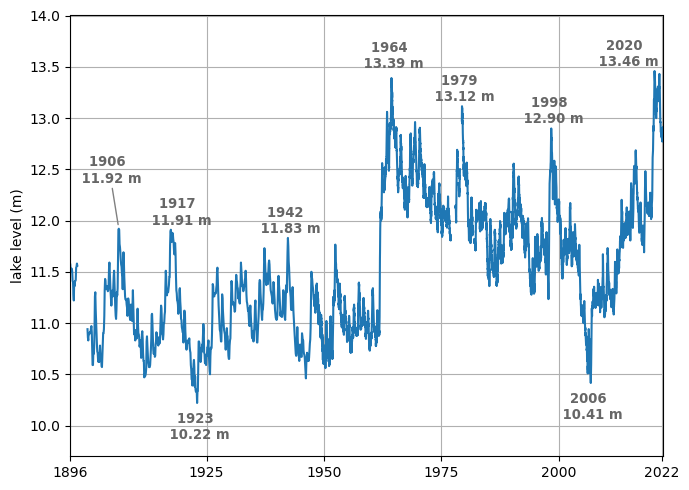

In [69]:
# plot Figure 1 of paper levels labelled
# UKCEH 1896-1948, hydromet 1948-1992, dahiti 1992-2022
# including also pre-1964 peaks 
# with 1917 peak as well
# with month-day

# Get extreme high levs
high_levs = unified_levels[unified_levels['water_level'] > 1136 - 1123.319]

# Get high levs before 1960s spike
high_levs = pd.concat([unified_levels[unified_levels['water_level'] > 11.7].loc[:'1963-01-01'], high_levs] )
list_years = np.unique(high_levs.index.year)

# Pick one per year
high_dates = []
high_levs_list =[]

for i in list_years:
    filter_condition = (high_levs.index.year == i)
    df_filter = high_levs.loc[filter_condition]
    maxL = max(df_filter['water_level'])
    maxday = df_filter[df_filter['water_level'] == maxL].index[0]
    high_levs_list.append(maxL)
    high_dates.append(maxday)
    
# Manually select only ones I want to show
data = {'date': high_dates,
        'level': high_levs_list
        }
df = pd.DataFrame(data)
df = df.sort_values(by='level', ascending=False).reset_index(drop=True)
select = [0,2,3,9,16,17,18] #  2020, 1964, 1979, 1998, 1906, 1917, 1942
df_select = df.iloc[select]

# Get low levels 
low_levs = unified_levels[unified_levels['water_level'] < 10.5]
list_years = np.unique(low_levs.index.year)

low_dates = []
low_levs_list =[]

for i in list_years:
    filter_condition = (low_levs.index.year == i)
    df_filter = low_levs.loc[filter_condition]
    minL = min(df_filter['water_level'])
    minday = df_filter[df_filter['water_level'] == minL].index[0]
    low_levs_list.append(minL)
    low_dates.append(minday)

# manually select which to show
data = {'date': low_dates,
        'level': low_levs_list
        }
df = pd.DataFrame(data)
df = df.sort_values(by='level', ascending=True).reset_index(drop=True)
#print(df)
select = [0,2]
df_select = pd.concat([df_select, df.iloc[select]])

# PLOT 

# set x axis labels
xlist = pd.to_datetime([1896, 1925, 1950, 1975,2000,2022], format='%Y')

fig, ax = plt.subplots(figsize=(7,5)) 
unified_levels.plot(ax=ax)
ax.grid(True)
plt.xlabel("")
plt.ylabel("lake level (m)")

# Set xaxis labels
ax.xaxis.set_ticks(xlist)
ax.xaxis.set_ticklabels(xlist.strftime("%Y"), rotation=0,ha='center')

# set plot limits
left = '1896-01-01'
right = '2022-03-03' #2022-03-03
ax.set_ylim(9.7 ,14) #9.51
ax.set_xlim(left, right)

# Add labels on extremes
for tick,label,i in zip(df_select['date'] , df_select['level'], range(len(df_select))):
    print(i)
    print(tick)
    #x
    if i == 0:
        tick_plot = tick - pd.Timedelta(days=(365*6))
    elif i in {5}:
        tick_plot = tick + pd.Timedelta(days=(365*1.8))
    elif i in {4}:
        tick_plot = tick - pd.Timedelta(days=(365*2))
    else: 
        tick_plot = tick
    # y
    if i in {4}:
        tick_y = label+0.45
    elif i in {8,7}:
        tick_y = label-0.35
    elif i in {1}:
        tick_y = label+0.1
    else:
        tick_y=label+0.05
        
    if i == 4:
        ax.annotate('{} \n {:.2f} m'.format(tick.strftime('%Y'), label), xy=(tick, label), xytext=(tick_plot, tick_y),
                    horizontalalignment='center', weight='heavy', color='0.4', fontsize=9.5,
                    arrowprops=dict(arrowstyle='-',shrinkA=0,shrinkB=3,color='gray')) #facecolor='0.4', shrinkB=100, width=0.1, headwidth=0
    else:
        ax.text(tick_plot, #x
                tick_y ,  #y
                '{} \n {:.2f} m'.format(tick.strftime('%Y'), label), #text tick.strftime('%Y-%m-%d')
                horizontalalignment='center', weight='heavy', color='0.4', #color 0.3
                fontsize=9.5)



plt.legend('',frameon=False)
fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'LL_plot_extended_1896_2022_insitu_monthday_arrow_light_v4.pdf'),dpi=300)